In [2]:
import os
import numpy as np

import pandas as pd
from pandas.plotting import andrews_curves
from pandas.plotting import parallel_coordinates

from sklearn.cluster import AgglomerativeClustering

import seaborn as sns

#matplotlib and related imports
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.patches import Patch
import matplotlib.patches as patches

from scipy.spatial import ConvexHull
from scipy.signal import find_peaks
from scipy.stats import sem
import scipy.cluster.hierarchy as shc

# import squarify

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as stattools
from statsmodels.tsa.seasonal import seasonal_decompose

from dateutil.parser import parse

from IPython.display import Image

# import geopandas
# import folium
# from folium.plugins import TimeSliderChoropleth
# from branca.element import Template, MacroElement

# Plot 1: Scatter plot

In [2]:
midwest = pd.read_csv("data/midwest_filter.csv")

In [3]:
midwest.head(3)

,PID,county,state,area,poptotal,popdensity,popwhite,popblack,popamerindian,popasian,...,percprof,poppovertyknown,percpovertyknown,percbelowpoverty,percchildbelowpovert,percadultpoverty,percelderlypoverty,inmetro,category,dot_size
0,561,ADAMS,IL,0.052,66090,1270.961540,63917,1702,98,249,...,4.355859,63628,96.274777,13.151443,18.011717,11.009776,12.443812,0,AAR,250.944411
1,562,ALEXANDER,IL,0.014,10626,759.000000,7054,3496,19,48,...,2.870315,10529,99.087145,32.244278,45.826514,27.385647,25.228976,0,LHR,185.781260
2,563,BOND,IL,0.022,14991,681.409091,14477,429,35,16,...,4.488572,14235,94.956974,12.068844,14.036061,10.852090,12.697410,0,AAR,175.905385


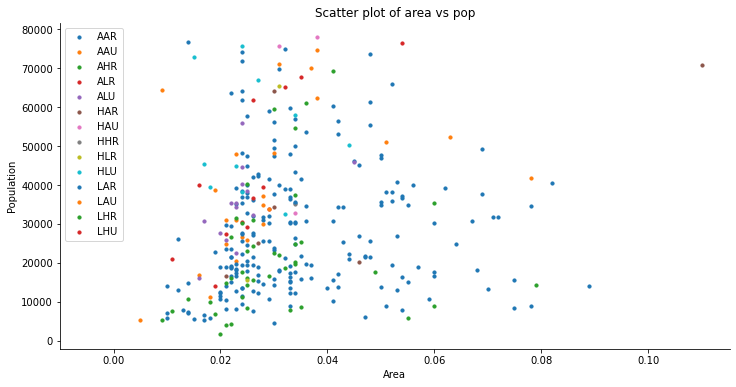

In [4]:
# instanciate the figure
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(1,1,1,)

for cat in sorted(list(midwest["category"].unique())):
    ar = midwest[midwest["category"] == cat]["area"]
    pop = midwest[midwest["category"] == cat]["poptotal"]
    
    ax.scatter(ar, pop, label = cat, s = 10)
    
ax.spines["top"].set_color("None")
ax.spines["right"].set_color("None")

ax.set_xlabel("Area")
ax.set_ylabel("Population")

ax.set_xlim(-0.01)
ax.set_title("Scatter plot of area vs pop")
ax.legend(loc = "best", fontsize = 10);

# Plot 2: Bubble plot with encircling

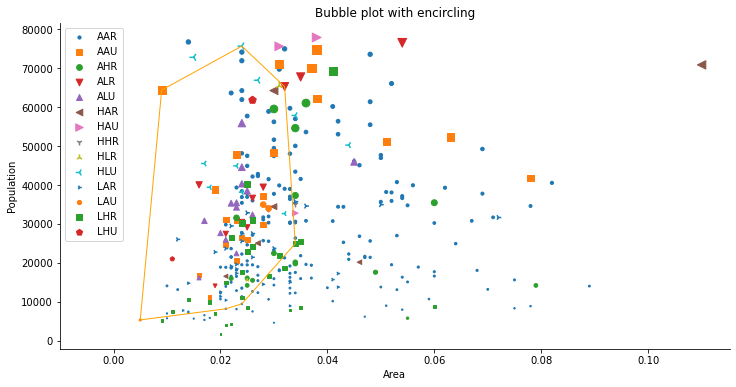

In [5]:
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(1,1,1)

size_total = midwest["poptotal"].sum()

markers = [".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", 
           "8", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d"]

for cat, marker in zip(sorted(list(midwest["category"].unique())), markers):
    ar = midwest[midwest["category"] == cat]["area"]
    pop = midwest[midwest["category"] == cat]["poptotal"]
    
    size = pop / size_total
    
    # plot the data
    ax.scatter(ar, pop, label = cat, s = size*10000, marker = marker);
    
encircle_data = midwest[midwest["state"] == "IN"]

encircle_x = encircle_data["area"]
encircle_y = encircle_data["poptotal"]

# concatenates over axis 1
p = np.c_[encircle_x, encircle_y]

hull = ConvexHull(p)

poly = plt.Polygon(p[hull.vertices, :], ec = "orange", fc = "none")

ax.add_patch(poly)

# prettify the plot
ax.spines["top"].set_color("None")
ax.spines["right"].set_color("None")

ax.set_xlabel("Area")
ax.set_ylabel("Population")

ax.set_xlim(-0.01)
ax.set_title("Bubble plot with encircling")
ax.legend(loc = "best", fontsize = 10);

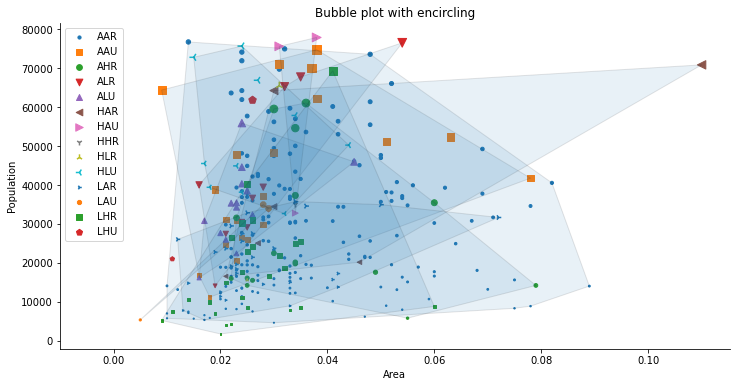

In [6]:
fig = plt.figure(figsize = (12, 6))

ax = fig.add_subplot(1,1,1)

size_total = midwest["poptotal"].sum()

markers = [".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", 
           "8", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d"]


def encircle(x,y, ax = None, **kw):
    '''
    Takes an axes and the x and y and draws a polygon on the axes.
    This code separates the differents clusters
    '''
    # get the axis if not passed
    if not ax: ax=plt.gca()
    
    # concatenate the x and y arrays
    p = np.c_[x,y]
    
    # to calculate the limits of the polygon
    hull = ConvexHull(p)
    
    # create a polygon from the hull vertices
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    
    # add the patch to the axes
    ax.add_patch(poly)
    
for cat, marker in zip(sorted(list(midwest["category"].unique())), markers):
    # filter x and the y for each category
    ar = midwest[midwest["category"] == cat]["area"]
    pop = midwest[midwest["category"] == cat]["poptotal"]
    
    # this will allow us to set a specific size for each group.
    size = pop/size_total
    
    # plot the data
    ax.scatter(ar, pop, label = cat, s = size*10000, marker = marker)
    
    try:
        # try to add a patch
        encircle(ar, pop, ec = "k", alpha=0.1)
    except:
        # if we don't have enough poins to encircle just pass
        pass

# prettify the plot
ax.spines["top"].set_color("None")
ax.spines["right"].set_color("None")

ax.set_xlabel("Area")
ax.set_ylabel("Population")

ax.set_xlim(-0.01)
ax.set_title("Bubble plot with encircling")
ax.legend(loc = "best", fontsize = 10);

# Plot 3: Scatter plot with linear regression line of best fit

In [3]:
mpg = pd.read_csv("data/mpg_ggplot2.csv")

In [5]:
mpg.head(3)

,manufacturer,model,displ,year,cyl,trans,drv,cty,hwy,fl,class
0,audi,a4,1.8,1999,4,auto(l5),f,18,29,p,compact
1,audi,a4,1.8,1999,4,manual(m5),f,21,29,p,compact
2,audi,a4,2.0,2008,4,manual(m6),f,20,31,p,compact


In [6]:
mpg_2 = mpg[mpg["cyl"].isin([4,8])]
mpg_2.head(2)

,manufacturer,model,displ,year,cyl,trans,drv,cty,hwy,fl,class
0,audi,a4,1.8,1999,4,auto(l5),f,18,29,p,compact
1,audi,a4,1.8,1999,4,manual(m5),f,21,29,p,compact


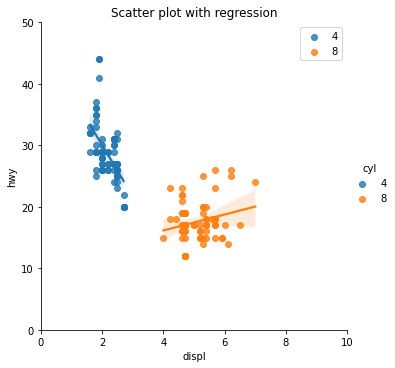

In [16]:
sns.lmplot(data = mpg_2, x = "displ", y = "hwy", hue = "cyl")

# prettify the graph
plt.gca().set_xlim(0, 10)
plt.gca().set_ylim(0, 50)

plt.title("Scatter plot with regression");

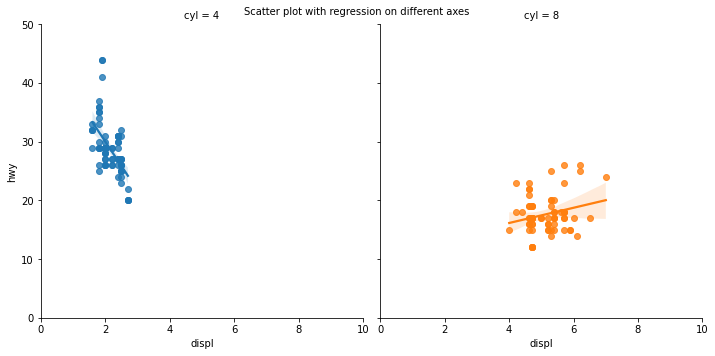

In [10]:
axes = sns.lmplot(data = mpg_2, x = "displ", y = "hwy", col = "cyl", hue = "cyl")

# prettify the graph
axes.set(xlim = (0, 10), ylim = (0, 50))

plt.suptitle("Scatter plot with regression on different axes", fontsize = 10);